# Plotting_USANS-USAXS_Compare

This script will create a plot that compares the neutron and x-ray scattering data for a single blends sample.

In [40]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from bumps.names import *
from bumps.fitters import fit

import sasmodels

from sasmodels.core import load_model
from sasmodels.bumps_model import Model, Experiment
from sasmodels.data import load_data, plot_data, empty_data1D
from sasmodels.direct_model import DirectModel

import sas

### Loading Sample Data and Meta-Data

In [2]:
# sample meta-data
sample_info = pd.read_csv('../data/sans/Sample_Info.csv')

# helpful meta-data dictionaries
names = dict(zip(sample_info['Sample'], sample_info['Name']))
cps = dict(zip(sample_info['Sample'], sample_info['Conjugated Polymer']))
matrix = dict(zip(sample_info['Sample'], sample_info['Commodity Polymer']))
solvent_names = dict(zip(sample_info['Sample'], sample_info['Solvent']))

# target weight percents of conjugated polymer
target = dict(zip(sample_info['Sample'], sample_info['Target Fraction']*100))

# fixing 401/402 and 403/404 sample pair target values for plotting colors only
target[401] = 0.5
target[402] = 0.1
target[403] = 5
target[404] = 1

# actual weight percentages
data = np.loadtxt('../data/uv_vis/Corrected_wtPercents.csv', delimiter=',', skiprows=1)
actual = {}
for key, tar, act, stdev, act_vol, stdev_vol in data:
    actual[key] = act


Loading reduced and compiled SANS and USANS data.

In [3]:
data_dir = '../data/sans/Smeared_Data_20200629/'
files = os.listdir(data_dir)
sans_data = {}
usans_data = {}
for file in files:
    if 'USANS' in file:
        key = int(file.split('_')[0][3:])
        usans_data[key] = load_data(data_dir + file)
    elif 'SANS' in file:
        key = int(file.split('_')[0][3:])
        sans_data[key] = load_data(data_dir + file)

In [133]:
data_dir = '../data/usaxs/'
files = os.listdir(data_dir)
usaxs_data = {}
for file in files:
    if 'mrg' in file:
        key = int(file.split('_')[4])
        data = np.loadtxt(data_dir + file, skiprows=1)
        mask = np.where(data[:,2]!=np.max(data[np.where(data[:,0]>1),2]))[0]
        if (len(data)-len(mask))>1:
            print('ERROR')
        else:
            data = data[mask,:]
        usaxs_data[key] = data

In [60]:
# useful dictionaries with labels and colors for the plots and their legends
wt_names = {} 
full_names = {}

wt_colors = {}
solvent_colors = {}
cp_colors = {}

rep_colors = {}
rep_names = {}

temp_wt_colors = {
    0.1: 'firebrick',
    0.5: 'darkorange',
    1.0: 'darkcyan',
    5.0: 'mediumblue',
    10.0: 'deeppink',
    25.0: 'darkorchid',
    50.0: 'forestgreen',
    0.0: 'black'
}

temp_solvent_colors = {
    'Chloroform': 'firebrick',
    'Bromobenzene': 'darkorange',
    'Toluene': 'darkcyan',
    'Slow Dry Chloroform': 'darkorchid'
}

temp_cp_colors = {
    'RRe-P3HT': 'firebrick',
    'RRa-P3HT': 'darkorange',
    'P3DDT': 'darkorchid',
    'PQT-12': 'darkcyan',
    'None': 'black'
}

for key in names.keys():
    if key in actual.keys():
        frac = actual[key]
    else:
        frac = target[key]
    frac = np.round(frac,2)
    
    if cps[key] == 'None':
        wt_names[key] = matrix[key] + ' Control'
        full_names[key] = matrix[key] + ' Control'
    else:
        wt_names[key] = str(frac) + ' wt% ' + cps[key]
        full_names[key] = str(frac) + ' wt% ' + cps[key] + ' in ' + matrix[key]
        
for key in cps.keys():
    wt_colors[key] = temp_wt_colors[target[key]]
    solvent_colors[key] = temp_solvent_colors[solvent_names[key]]
    cp_colors[key] = temp_cp_colors[cps[key]]


### Creating common plotting function

In [156]:
def plot_sans(keys,sans_data_dict,usans_data_dict,usaxs_data_dict,zorders,label_dict,color_dict,filename,title=None,legend_title=None, size=5):
    
    
    make_colors = {}
    if type(color_dict) is list:
        print('converting color list')
        i = 0
        for key in keys:
            make_colors[key] = color_dict[i]
            i += 1
        color_dict = make_colors
    
    make_labels = {}
    if type(label_dict) is list:
        print('converting label list')
        i = 0
        for key in keys:
            make_labels[key] = label_dict[i]
            i += 1
        label_dict = make_labels
            
            
    fig, ax1 = plt.subplots(figsize=(6,6))
    
    left, bottom, width, height = [0.57, 0.55, 0.3, 0.3]
    ax2 = fig.add_axes([left, bottom, width, height])
    
    i = 0
    for key in keys:
        sans_data = sans_data_dict[key]
        
        ax1.errorbar(sans_data.x, sans_data.y, yerr=sans_data.dy, zorder = zorders[i]*10, label='Neutron Scattering', c='firebrick', ms=size, fmt='o')
        
        if key in usans_data_dict.keys():
            usans_data = usans_data_dict[key]
            ax1.errorbar(usans_data.x, usans_data.y, yerr=usans_data.dy, zorder = zorders[i]*10, label=None, c='firebrick', ms=size, fmt='o')
    
        usaxs_data = usaxs_data_dict[key]
        
        max_int = np.max(usaxs_data[np.where((usaxs_data[:,0]>1)&(usaxs_data[:,0]<2))[0],1])*1.2
        
        ax1.errorbar(usaxs_data[:,0], usaxs_data[:,1], yerr=usaxs_data[:,2], zorder=zorders[i], label='X-ray Scattering', c='mediumblue', ms=size, fmt='o')
        ax2.errorbar(usaxs_data[:,0], usaxs_data[:,1], yerr=usaxs_data[:,2], zorder=zorders[i], label=None, c='mediumblue', ms=size, fmt='-')
    
    ax1.set_xscale('log')
    ax1.set_yscale('log')

    ax1.set_xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    ax1.set_ylabel(r'I(Q)', fontsize=16)
    
    legend = ax1.legend(loc='upper left')
    plt.setp(legend.get_title(),fontsize=14)

    ax1.set_ylim(1e-03, 1e11)
    ax1.set_xlim(0.00002, 6)


    ax2.set_xlabel(r'Q ($\AA^{-1}$)', fontsize=16)
    ax2.set_ylabel(r'I(Q)', fontsize=16)
    
    ax2.set_ylim(0,max_int)
    ax2.set_xlim(0,3)

#     if title is not None:
#         plt.title(title, fontsize=16)
    ax1.set_title(label_dict[key]+'\nCast from '+solvent_names[key], fontsize=16)
    
    #ax1.tight_layout()

    plt.savefig(filename, dpi=600)
    
    #plt.close()

### Plotting Concentration Series

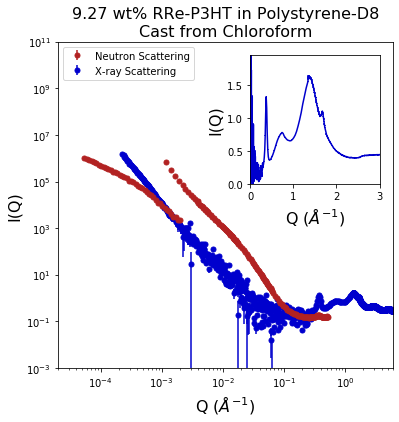

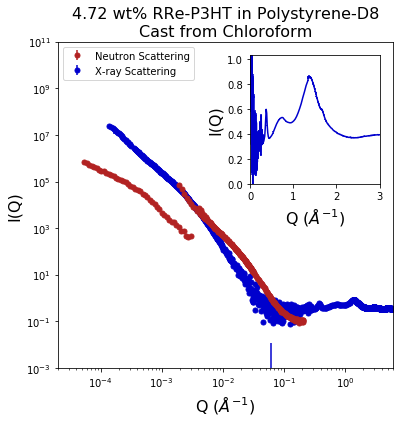

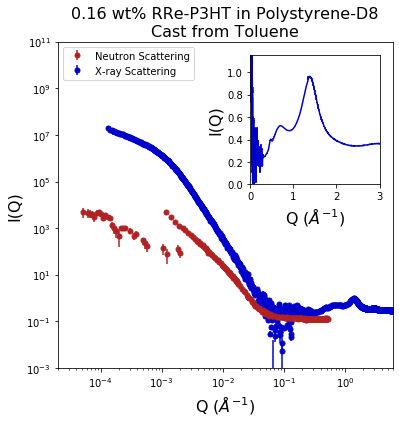

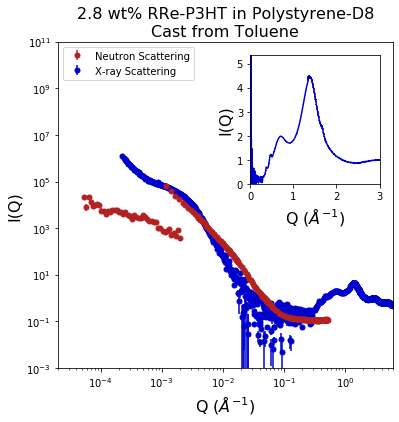

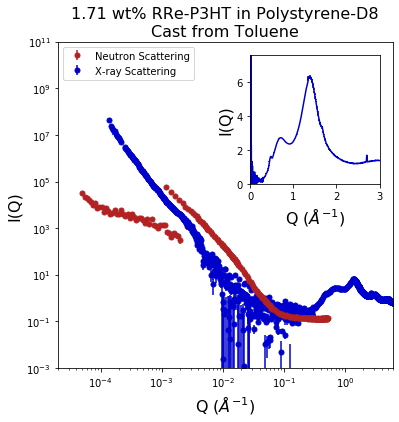

In [158]:
save_loc = '../data/sans/SANS_Figures/'
os.makedirs(save_loc, exist_ok=True)

plot_sans([112],sans_data,usans_data,usaxs_data,[1],full_names,wt_colors, save_loc +'USANS_USAXS_compare112.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_sans([4],sans_data,usans_data,usaxs_data,[1],full_names,wt_colors, save_loc +'USANS_USAXS_compare4.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_sans([402],sans_data,usans_data,usaxs_data,[1],full_names,wt_colors, save_loc +'USANS_USAXS_compare402.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_sans([403],sans_data,usans_data,usaxs_data,[1],full_names,wt_colors, save_loc +'USANS_USAXS_compare403.png',title='RRe-P3HT in PS-D8 from Toluene')
plot_sans([404],sans_data,usans_data,usaxs_data,[1],full_names,wt_colors, save_loc +'USANS_USAXS_compare404.png',title='RRe-P3HT in PS-D8 from Toluene')

